# Neural Kalman Filters

This notebook demonstrates the training and testing of a ***Neural Kalman Filter*** (NKF) on simulated data of Radar detections.

The following modules were implemented for the NKF (note that some are deprecated as mentioned below):
- Acceleration prediction
- $Q$ prediction (with diagonal constraint)
- Observation model ($H$) prediction (deprecated - very unstable)
- $R$ prediction (with diagonal constraint)
- Mixture-of-Gaussians representation (deprecated - no significant improvement)

The NKF achieved significant improvement over the standard KF.
However, as shown below, by changing the baseline from a standard KF (with estimated parameters) to an ***Optimized KF*** (OKF, with optimized parameters), NKF has no added value anymore.
In other words, it seems that the NKF (as implemented in this work, at least) does not provide beneficial expressiveness for the problem, but only enjoys the optimization itself - which can be obtained with far less trouble.

In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pickle as pkl
from collections import Counter
import gc

import torch
import torch.nn.functional as F

import utils
import TargetSimulator as Sim
import SensorGenerator as Rad
import Trackers
import NeuralTrackers as NT
import TrackingLab as TLAB
import PredictionLab as PLAB

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

# Generate data

In [3]:
ID = 0

### Set configuration

In [4]:
def get_scenario(max_acc=0, n_episodes=1000, n_targets=1, n_turns=3, p_vertical=0.3, seed_base=0,
                 old_mode=True, noise=1, far=0, title=None, train=False):
    if title is None:
        title = 'train' if train else 'test'
    seeds = seed_base + np.arange(n_episodes)
    
    return dict(
        targets = dict(
            n_episodes = n_episodes,
            dt = 1,
            old_mode = old_mode,
            acc = max_acc,
            n_targets_args = dict(n1=n_targets-3, n2=n_targets+4) if n_targets>3 else n_targets,
            init_args=dict(t0=10, dt=3, X0=(0,0,0), dx=(4e3,4e3,4e2), V0=(50,0,90), dV=(15,10000,6),
                           unif_x=True, unif_v=False), # dx=(2e3,2e3,1e2)
            n_turns_args = dict(n1=n_turns-1, n2=n_turns+2) if n_turns>1 else n_turns,
            line_args = dict(p_acc=0.5, t_mean=12, t_sigma=3, t_mean_acc=6, t_sigma_acc=2, vmax0=150),
            turn_args = dict(p_vertical=p_vertical, p_left=0.5, a_mean=45, a_sigma=270, vertical_fac=0.1),
            seeds = seeds,
            title = title,
        ),
        radar = dict(
            noise_factor = noise,
            FAR = 0, # TODO FAR & missing detections
        )
    )

In [5]:
title = f'benchmark{ID:02d}'
p_vertical = 0.12
a_test = (24,48,96) # (24,48,96)
a_train = (48,)
test_episodes = 100 # 100
train_episodes = 4000 # 4000
n_turns = 3
noise = 1
scenarios  = [get_scenario(a_train, n_episodes=train_episodes, n_targets=1, n_turns=n_turns,
                           p_vertical=p_vertical, noise=noise, seed_base=0, train=True)]
scenarios += [get_scenario(a_test, n_episodes=test_episodes, n_targets=20, n_turns=n_turns,
                           p_vertical=p_vertical, noise=noise, seed_base=train_episodes)]
scenarios  = {sc['targets']['title']:sc for sc in scenarios}

scenarios.keys()

dict_keys(['train', 'test'])

### Generate

['train', 'test']
Generating scenario train... done.	(95 [s])
Generating scenario test... done.	(36 [s])
4000 4000 (77, 4) (77, 6) 19.0 240.0 Counter({'24<acc<48': 4000})
Wall time: 2min 39s


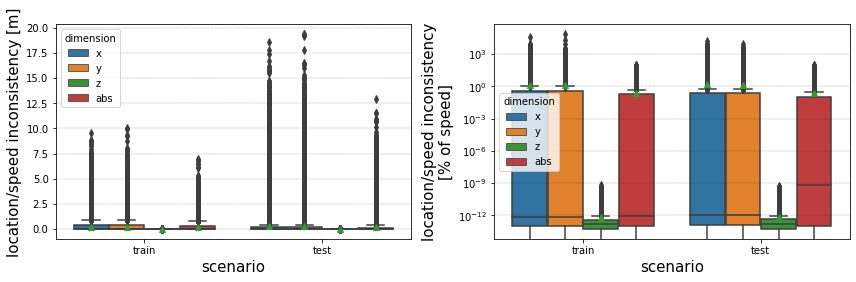

In [6]:
%%time
GENERATE = True
if GENERATE:
    # Generate data
    E = PLAB.create_experiment(scenarios=scenarios, title=title, load=False)
    E.meta_episodes.loc[E.meta_episodes.seed>=(train_episodes), 'group'] = 1
    E.meta_targets.loc[E.meta_targets.seed_ep>=(train_episodes), 'group'] = 1
    E.save_data()
    X, Y, scenarios_train = PLAB.get_group_data(E, 0)
    X2, Y2, scenarios_test = PLAB.get_group_data(E, 1)
    PLAB.save_data(X, Y, scenarios_train, fname=f'train{ID:02d}')
    PLAB.save_data(X2, Y2, scenarios_test, fname=f'test{ID:02d}')
    print(len(X), len(Y), X[0].shape, Y[0].shape, np.min(E.meta_targets['T']), np.max(E.meta_targets['T']), Counter(scenarios_train))

else:
    # just load
    E = PLAB.create_experiment(title=title, load=True)
    X, Y, scenarios_train = PLAB.get_group_data(E, 0)
    X2, Y2, scenarios_test = PLAB.get_group_data(E, 1)
    print(len(X), len(Y), X[0].shape, Y[0].shape, np.min(E.meta_targets['T']), np.max(E.meta_targets['T']), Counter(scenarios_train))

dd = E.targets_consistency_test()

### Load

In [7]:
X,Y,scenarios_train = PLAB.load_data(fname=f'train{ID:02d}')
X2,Y2,scenarios_test = PLAB.load_data(fname=f'test{ID:02d}')

#### Sample target

In [8]:
story, info = E.get_target_story()
print(info)
story

{'max_acc': 96, 'time': 36.0}


phase      mode  time        acc   direct       angle
0      0  straight     6  75.042747  forward    0.000000
1      1      turn     4  16.094150     down  -20.581769
2      2  straight     6  59.927732  forward    0.000000
3      3      turn     8  49.299850     left -136.521071
4      4  straight     6  80.937744  forward    0.000000
5      5      turn     3  85.172373     left  -90.698091
6      6  straight     4  83.739090  forward    0.000000

#### Trajectories lengths

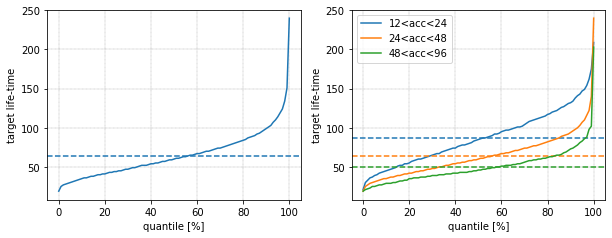

In [9]:
axs = utils.Axes(2)

utils.plot_quantiles(E.meta_targets['T'], plot_mean=True, ax=axs[0])
axs[0].set_xlabel('quantile [%]')
axs[0].set_ylabel('target life-time');

for cls in np.unique(E.meta_targets.target_class):
    utils.plot_quantiles(E.meta_targets[E.meta_targets.target_class==cls]['T'], plot_mean=True, label=cls, ax=axs[1])
axs[1].legend()
axs[1].set_xlabel('quantile [%]')
axs[1].set_ylabel('target life-time');

Text(0, 0.5, 'total time steps in data')

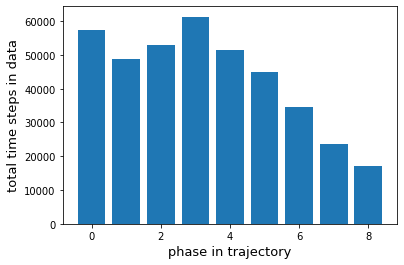

In [10]:
tmp = Counter(pd.concat([tar for sc in E.scenarios for ep in E.targets[sc] for tar in ep]).phase)
plt.bar(tmp.keys(), tmp.values())
plt.xlabel('phase in trajectory', fontsize=13)
plt.ylabel('total time steps in data', fontsize=13)

#### Sample targets

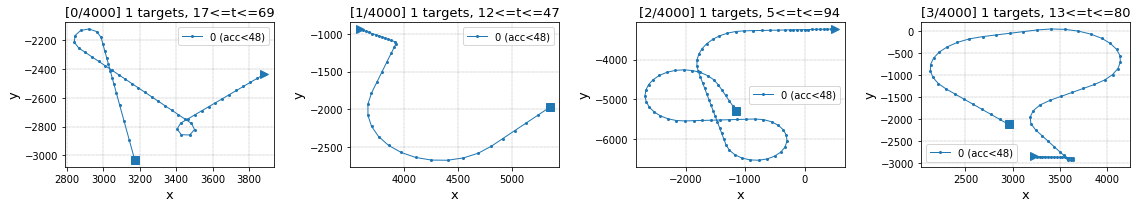

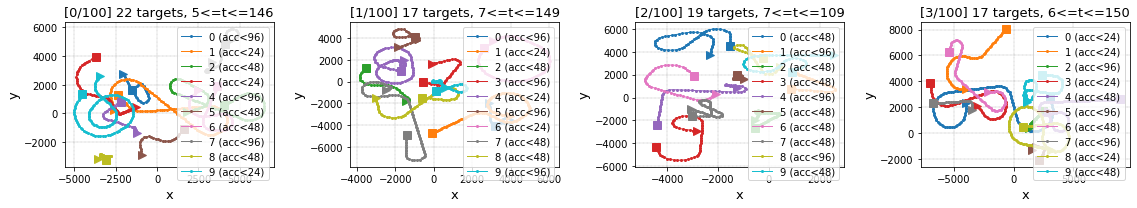

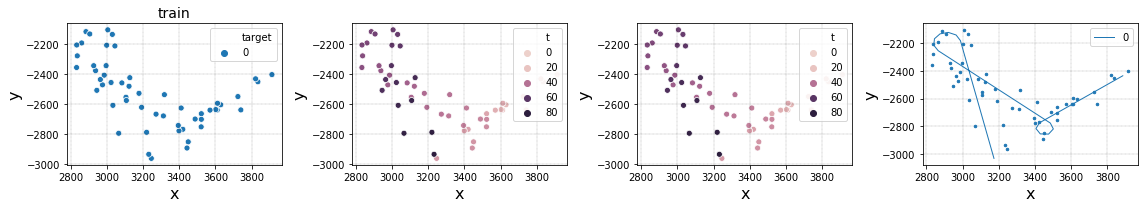

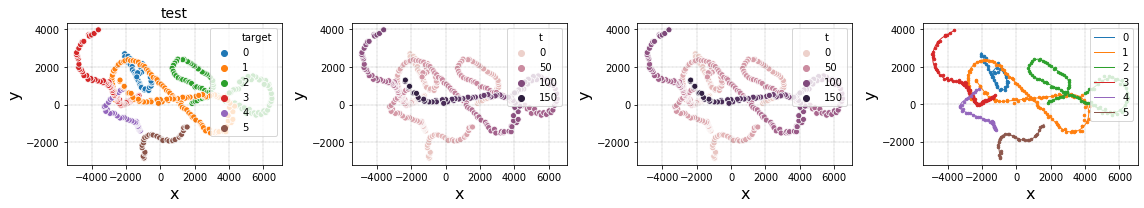

In [11]:
E.show_episodes(episodes_per_scenario=4, max_targets=10)
E.show_detections()

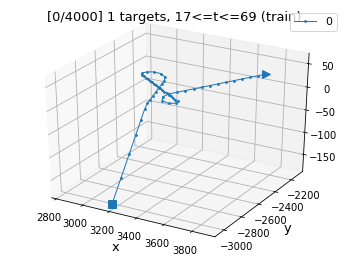

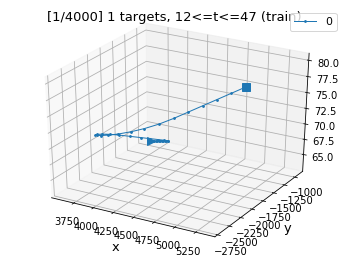

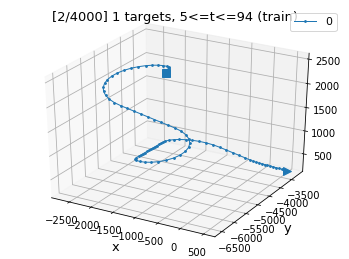

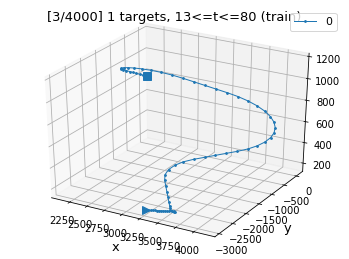

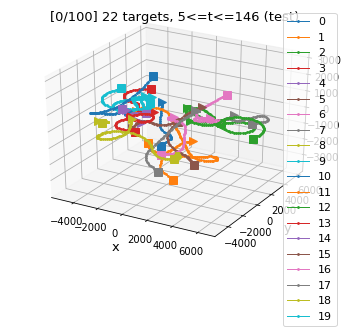

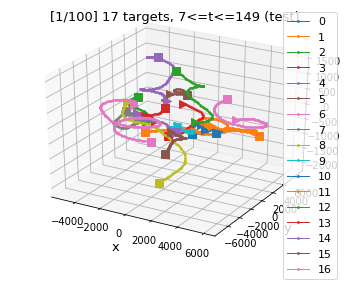

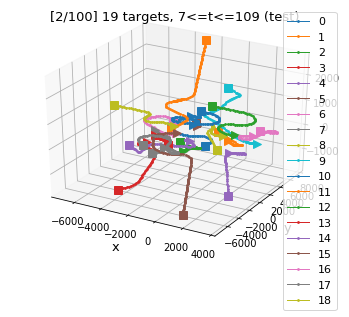

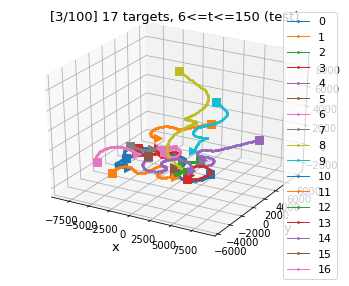

In [12]:
for sc in E.scenarios:
    Sim.show_episodes_3D(E.targets[sc], E.target_args[sc], max_episodes=4, max_targets=20, tit=sc)

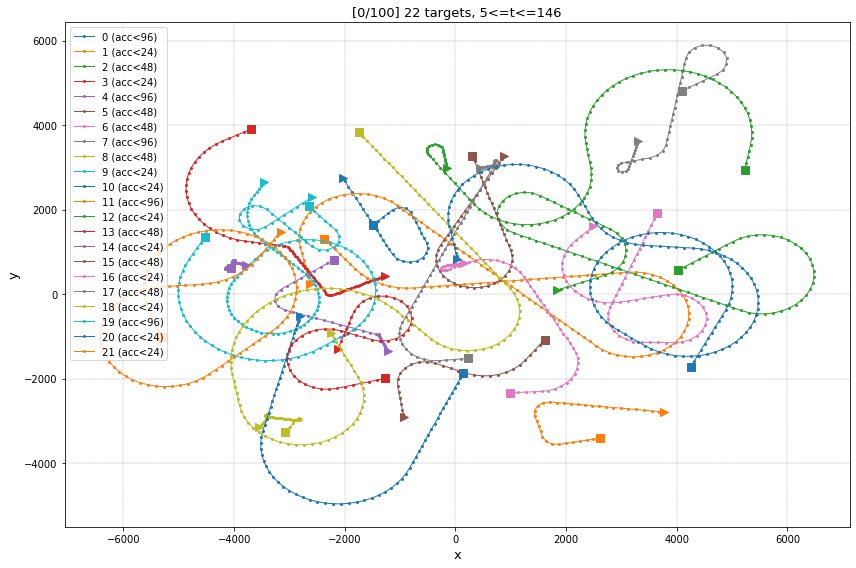

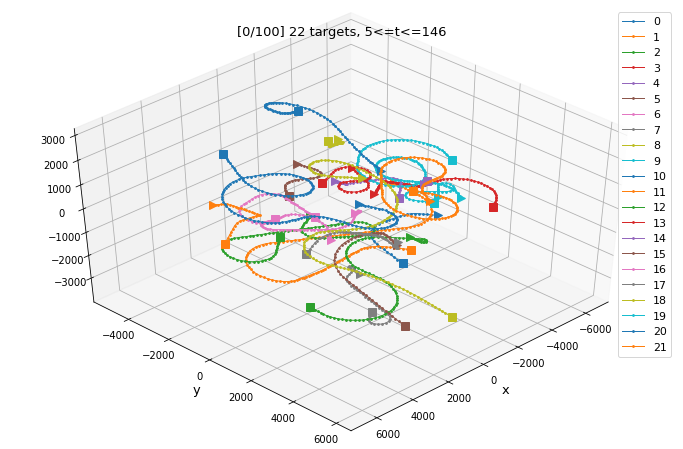

In [13]:
E.show_episodes(scenarios=['test'], episodes_per_scenario=1, max_targets=24, axs=utils.Axes(1,1,axsize=(12,8)))
axs = Sim.show_episodes_3D(E.targets['test'], E.target_args['test'], max_episodes=1, max_targets=24, figsize=(12,8))
axs[0].view_init(45, 45)

# Train models

In [14]:
models_args = [
    dict(load=False, title='KFc', no_acc=True),
    dict(load=False, title='KFp', no_acc=True, polar_R=True),
    dict(load=False, title='OKFc', no_acc=True, const_R=False, const_Q=False),
    dict(load=False, title='OKFp', no_acc=True, const_R=False, const_Q=False, polar_R=True),
    dict(load=False, title='NKFc', dynamic_Q='nn', dynamic_R=True),
    dict(load=False, title='NKFp', dynamic_Q='nn', dynamic_R=True, polar_R=True),
]

gc.collect()

124349

Waiting for trainings...
Waiting for processes...
Done.	(55745 [s])
Best validation losses:
	KFc: inf (KFc_s00), inf (KFc_s02), inf (KFc_s01)
	KFp: inf (KFp_s00), inf (KFp_s01), inf (KFp_s02)
	OKFc: 111 (OKFc_s02), 111 (OKFc_s01), 111 (OKFc_s00)
	OKFp: 108 (OKFp_s00), 108 (OKFp_s01), 108 (OKFp_s02)
	NKFc: 110 (NKFc_s00), 110 (NKFc_s01), 111 (NKFc_s02)
	NKFp: inf (NKFp_s01), 131 (NKFp_s00), 112 (NKFp_s02)


D:\Code\Python\RadarSimulator\utils.py:259: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
D:\Code\Python\RadarSimulator\utils.py:259: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
D:\Code\Python\RadarSimulator\PredictionLab.py:1098: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


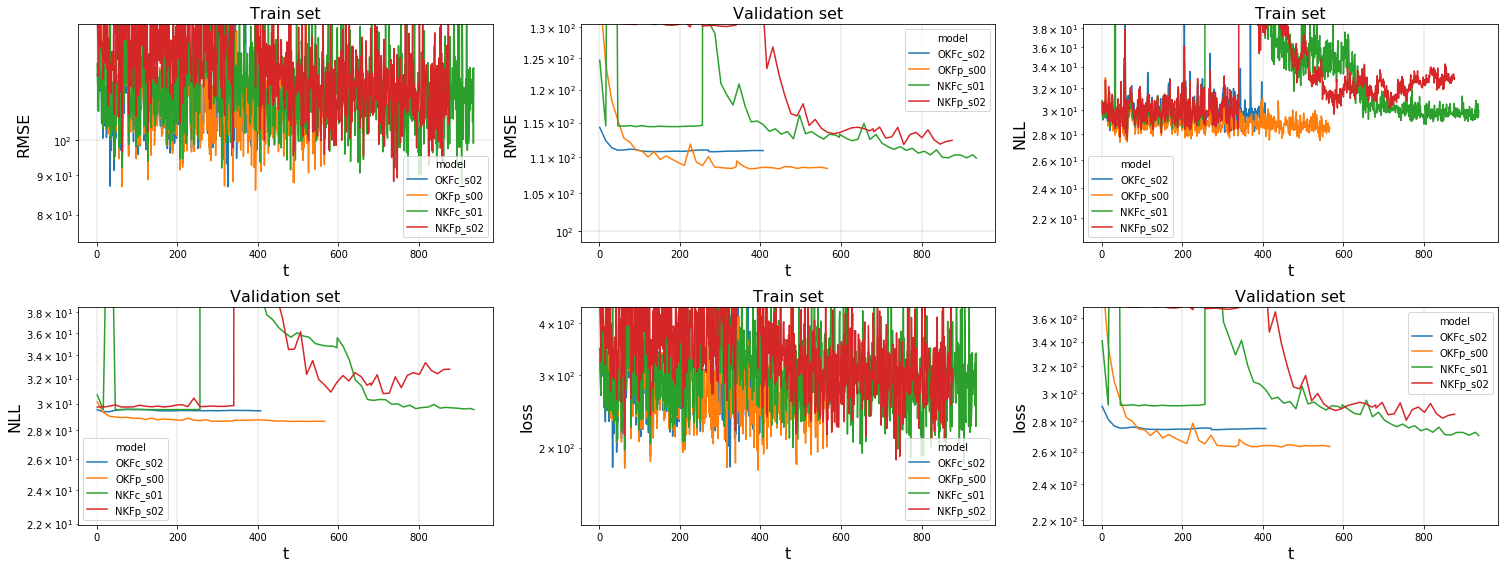

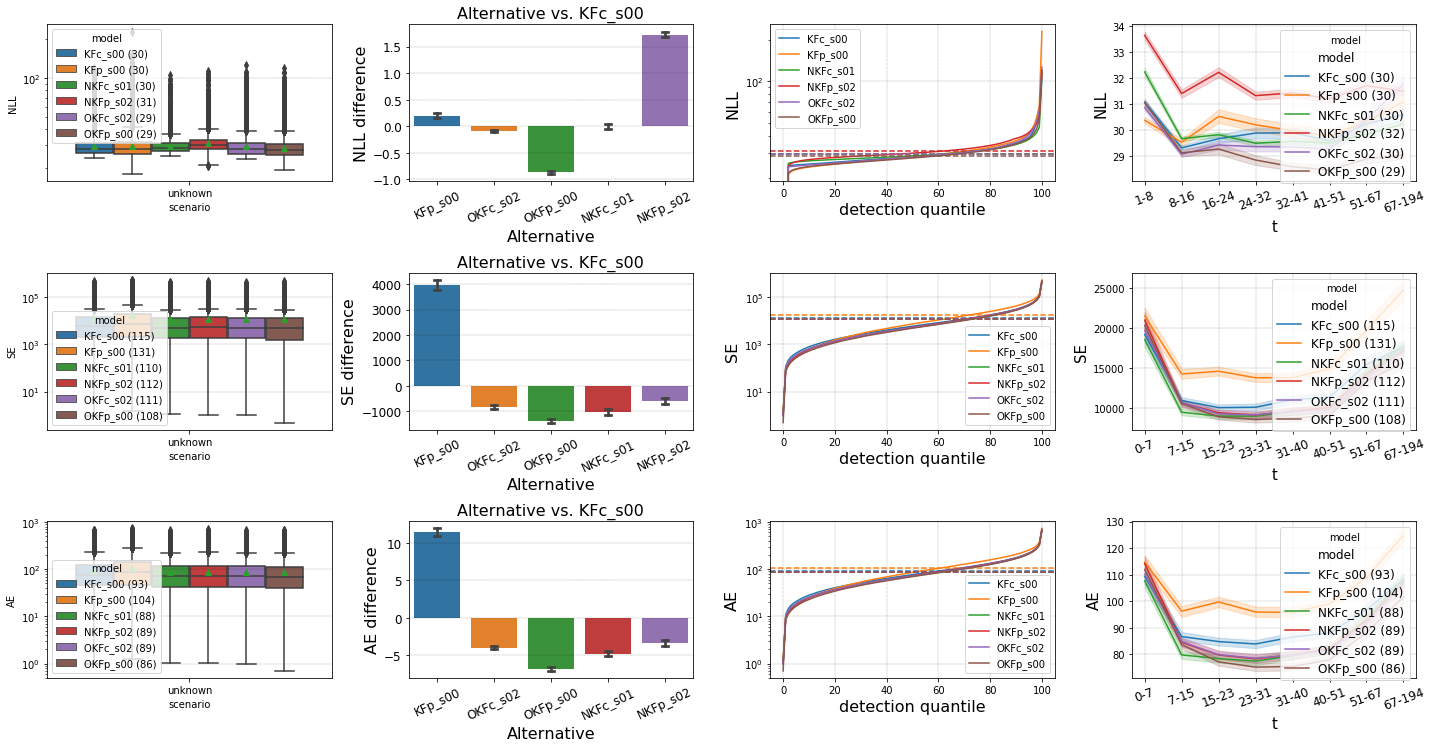

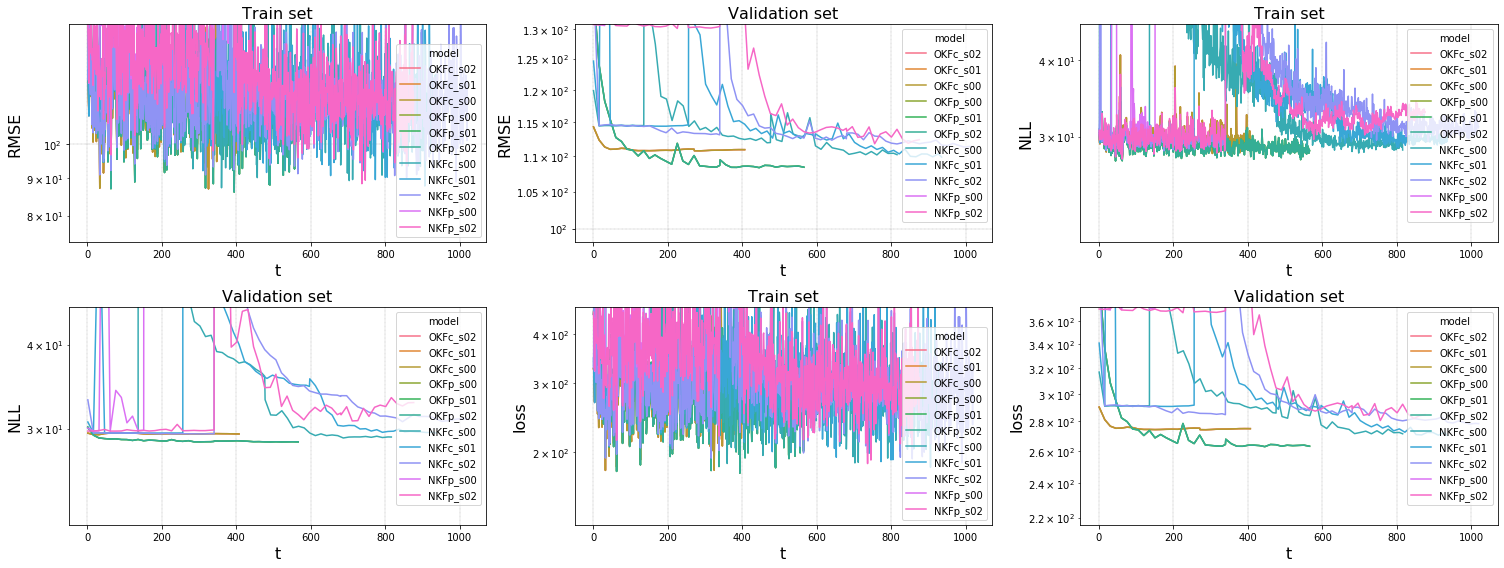

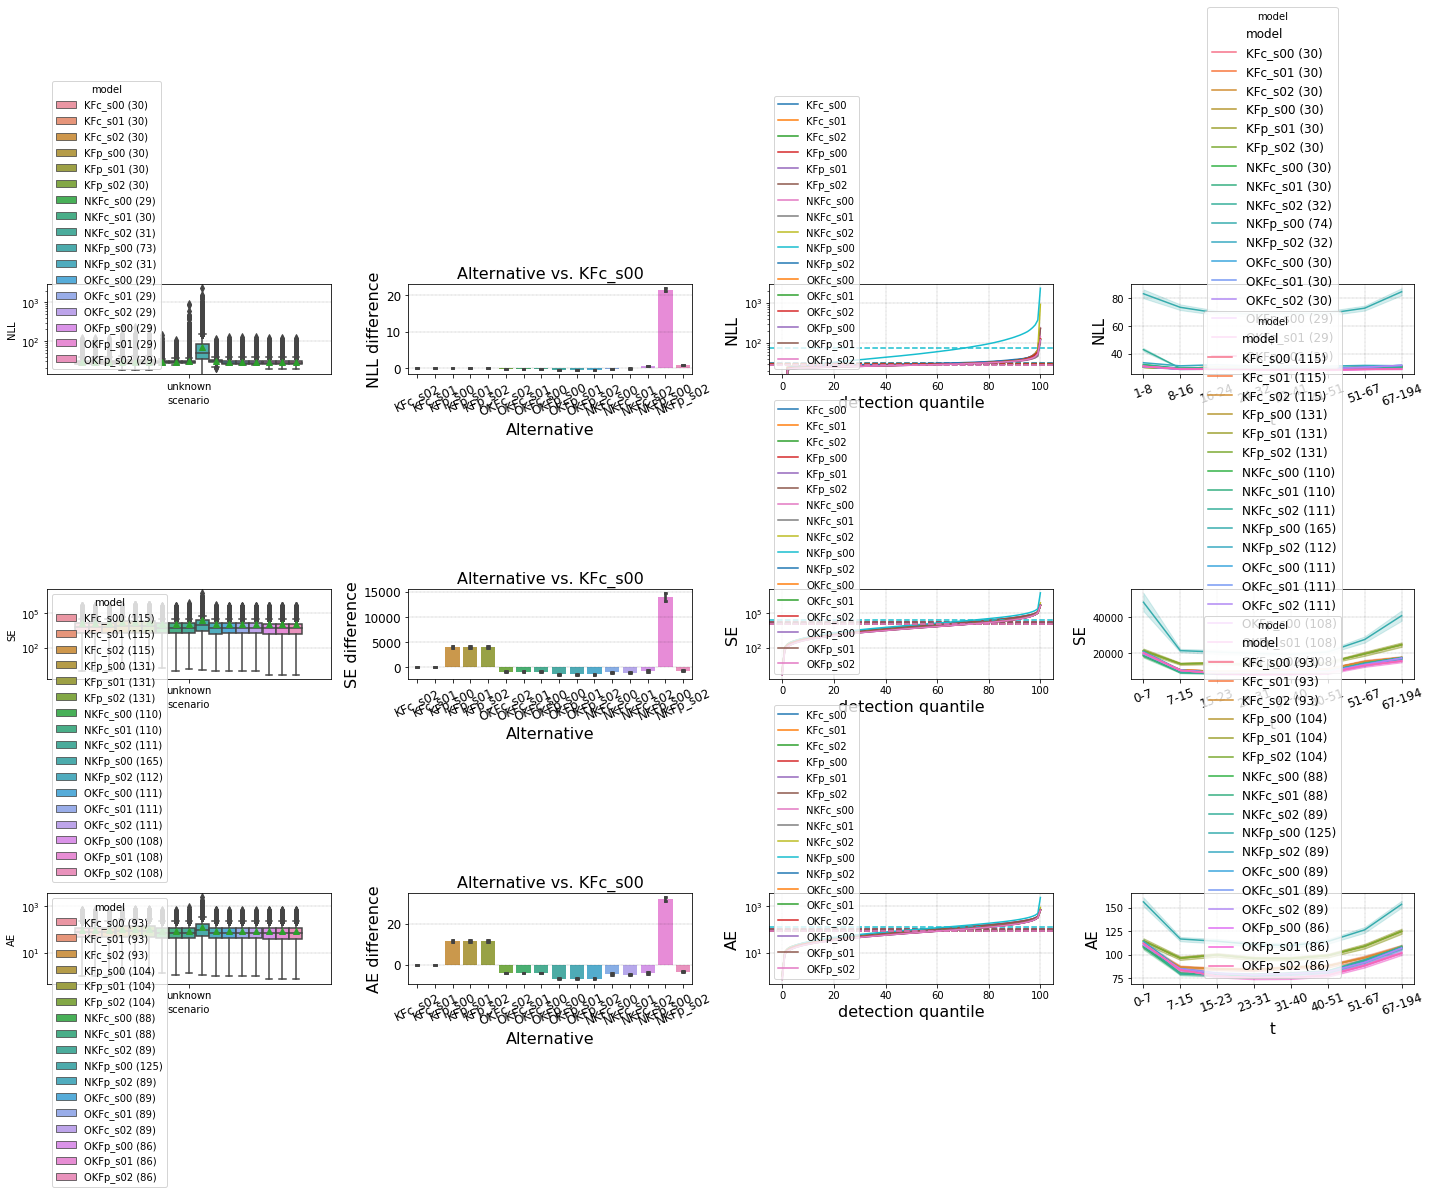

In [16]:
seeds = 3 # train each variant multiple times with different initializations (seeds), and choose the best one according to the validation data

# train
models, train_res, valid_res, ddt, ddv, losses = \
    PLAB.train_models(models_args, X, Y, seeds=seeds, save_res=f'data{ID:02d}', model_fname_prefix=f'data{ID:02d}', n_epochs=2, batch_size=20,
                      tune_phase=True, batch_fac=1, lr_fac=0.5, lr=1e-2, lr_decay=0.5, lr_decay_freq=150, verbose=2)

# show results of chosen models
PLAB.train_summary(train_res, ylim_quant=90);
PLAB.test_analysis(valid_res);

# show results of all models
if seeds > 1:
    PLAB.train_summary(ddt, ylim_quant=90);
    PLAB.test_analysis(ddv);

# Test models

6 models are split to 1 batches.
Running 8 threads...
Finished models-batch 1/1.	(732 [s])


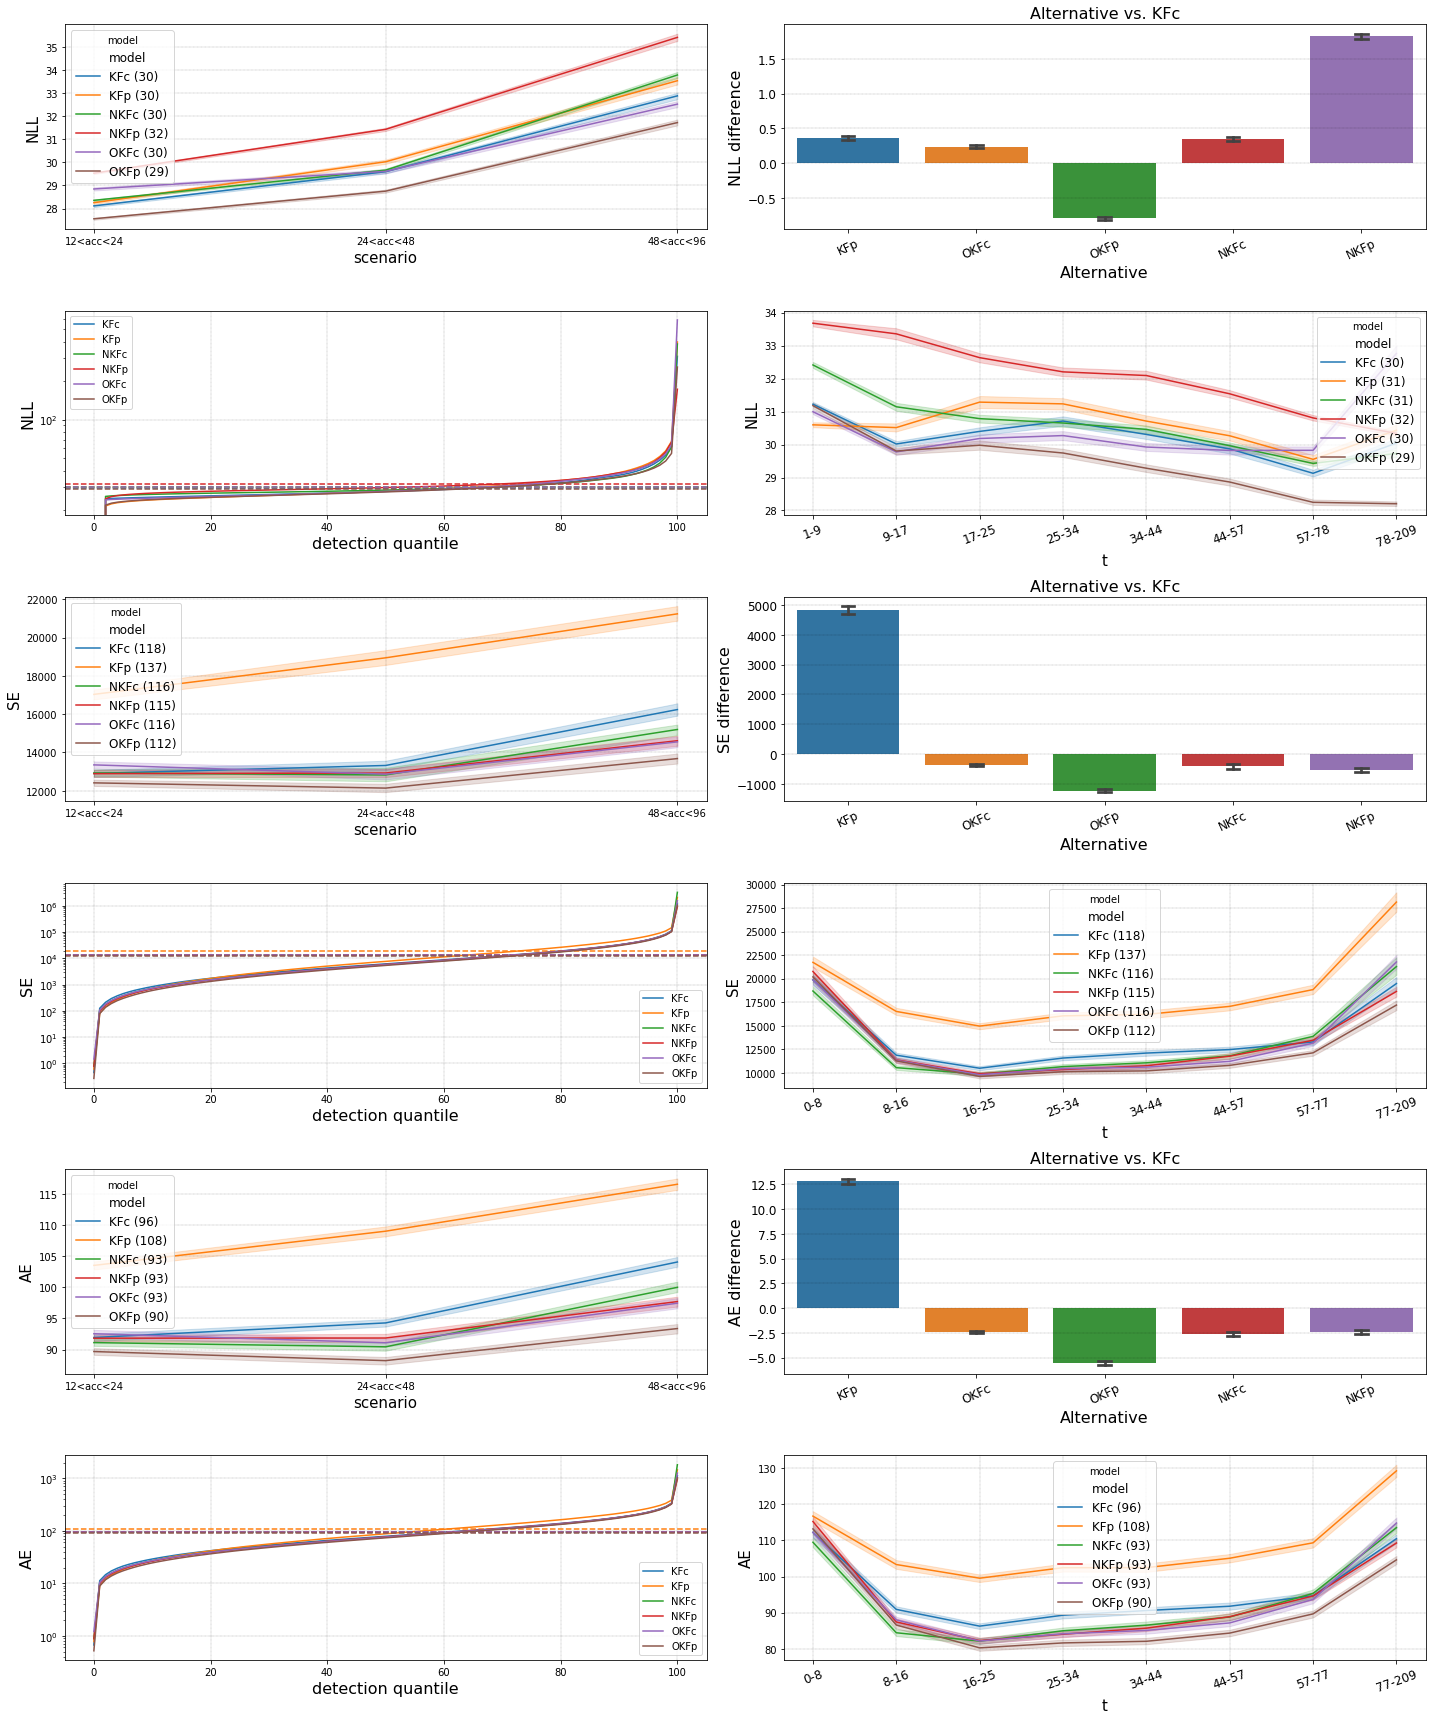

In [17]:
res = PLAB.test_models(models, X2, Y2, scenarios_test)
axs = PLAB.test_analysis(res, axargs=dict(W=2, axsize=(10,4)))

Results of KF,NKF,OKF_p only:

C:\Users\idogr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


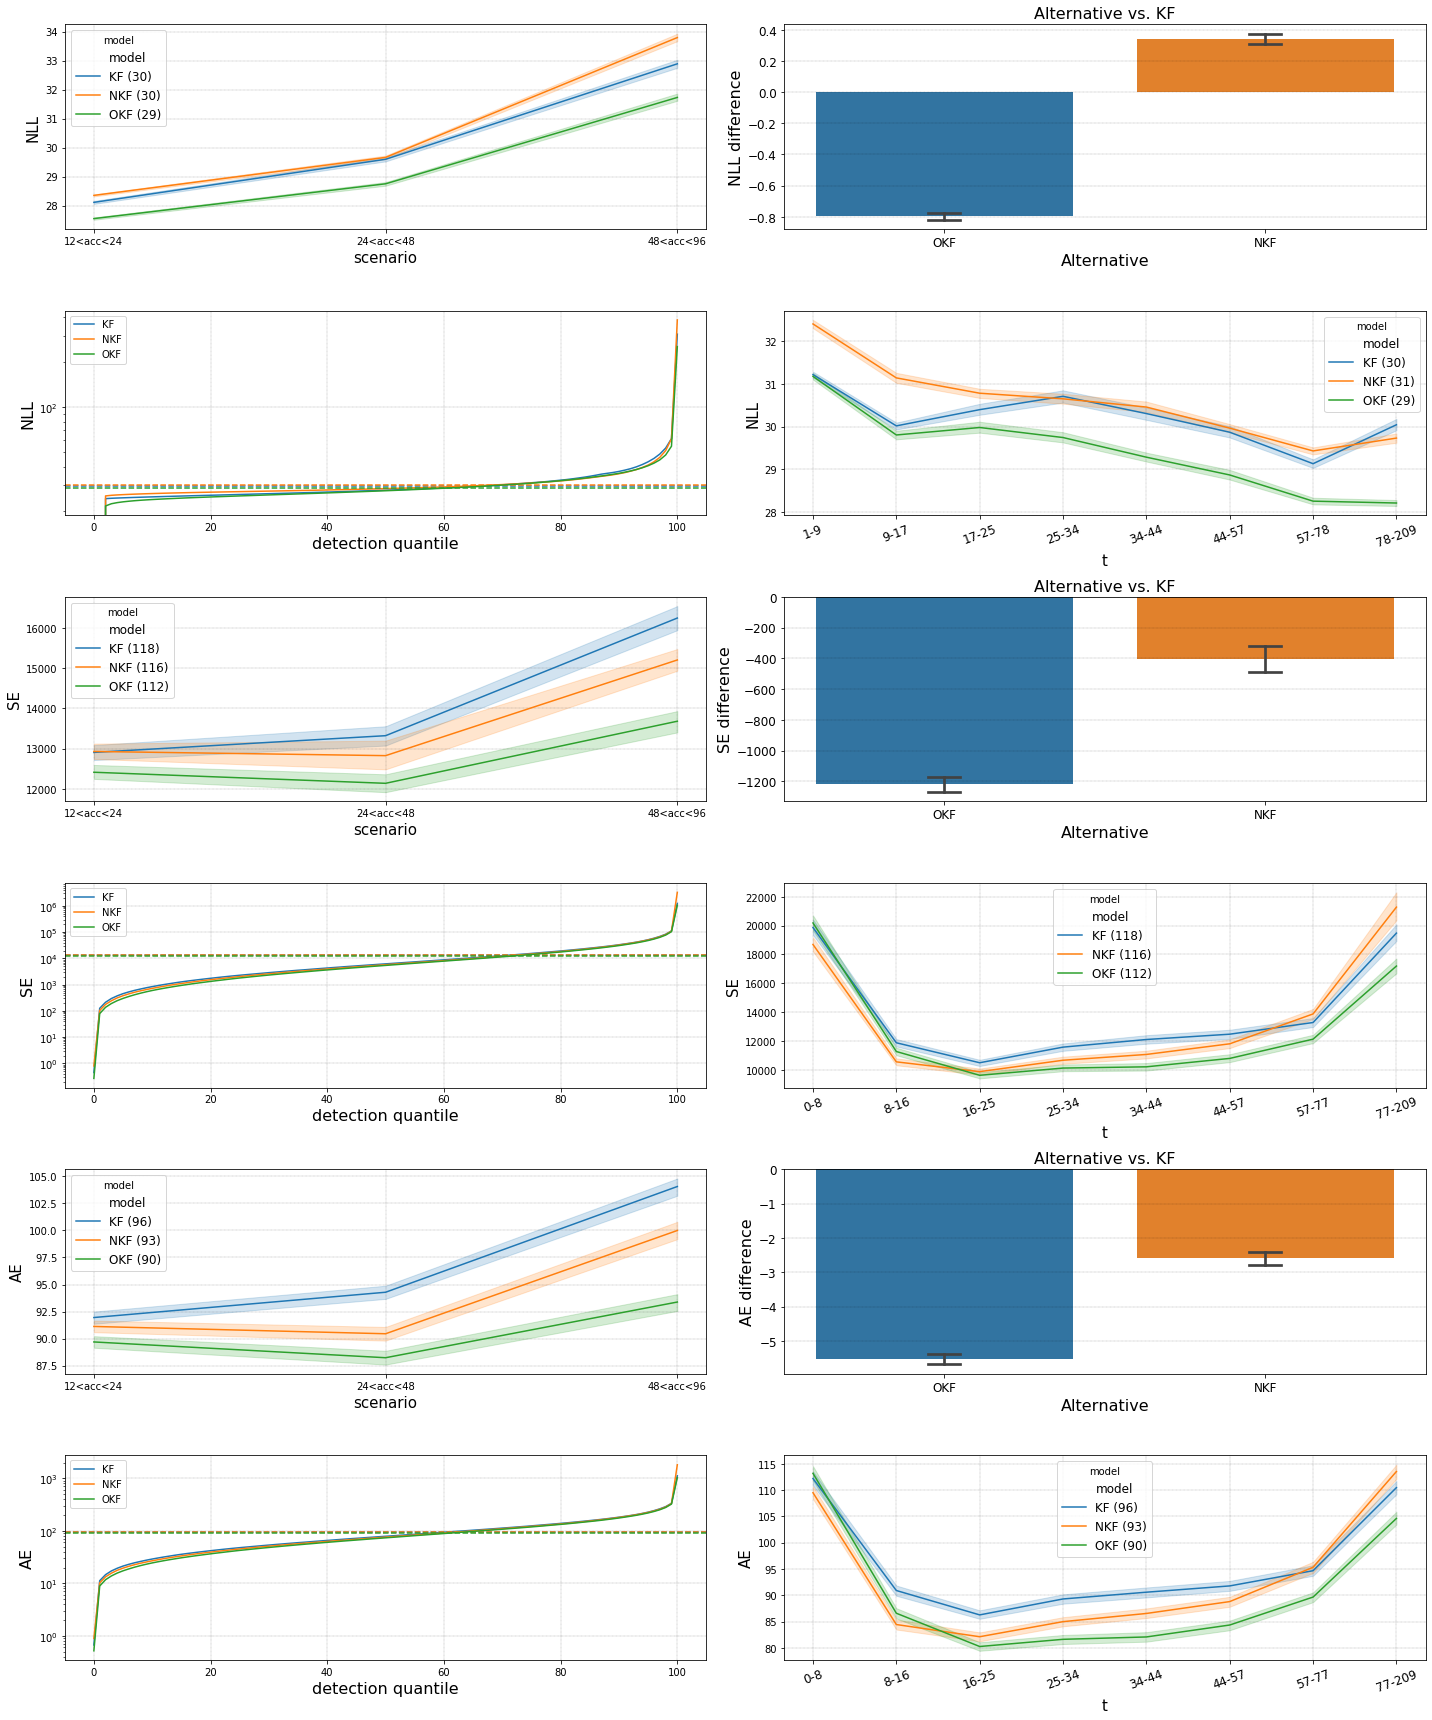

In [18]:
res2 = res[res.model.isin(('KFc','NKFc','OKFp'))]
res2['model'] = [m[:-1] for m in res2.model]
axs = PLAB.test_analysis(res2, axargs=dict(W=2, axsize=(10,4)))

TODO display results over a sample of targets (plot trajectories or show likelihood-colormap).

# Test models in complete tracking task

In [19]:
title=f'benchmark{ID:02d}'
E = PLAB.create_experiment(title=title, load=True)

In [20]:
tracker_args = [
    dict(load=False, title='KF', no_acc=True),
    dict(load=False, title='OKF_p', no_acc=True, const_R=False, const_Q=False, polar_R=True),
    dict(load=False, title='NKF', dynamic_Q='nn', dynamic_R=True),
]

for i in range(len(tracker_args)):
    tracker_args[i]['load'] = f"data{ID:02d}_{tracker_args[i]['title']}"

E.solvers_args = {}
E.solvers_args['Naive'] = ((Trackers.HungarianAssigner,{}), (Trackers.NaiveTracker, dict()))
for args in tracker_args:
    E.solvers_args[args['title']] = ((Trackers.HungarianAssigner,dict(match_thresh=np.inf)), (NT.NeuralKF, args))

E.initialize_solvers()

In [21]:
SAVE_RES = f'benchmark{ID:02d}_res'
E.run_scenarios(group=1, do_save=SAVE_RES, distributed=True, gb_per_job=4)

Running train...
Reduced distribution to 10 cores to fit into 51GB.
 done.	(0 [s])
Running test...
Reduced distribution to 10 cores to fit into 51GB.
	Batch 0 starts...
	Batch 1 starts...
	Batch 2 starts...
	Batch 3 starts...
	Batch 4 starts...
	Batch 5 starts...
	Batch 6 starts...
	Batch 7 starts...
	Batch 8 starts...
	Batch 9 starts...
		[02/10] episode 005/010 done.	(170.8 [s])
		[03/10] episode 005/010 done.	(169.0 [s])
		[00/10] episode 005/010 done.	(178.3 [s])
		[04/10] episode 005/010 done.	(169.1 [s])
		[05/10] episode 005/010 done.	(179.8 [s])
		[01/10] episode 005/010 done.	(196.7 [s])
		[08/10] episode 005/010 done.	(179.5 [s])
		[07/10] episode 005/010 done.	(182.9 [s])
		[06/10] episode 005/010 done.	(188.4 [s])
		[09/10] episode 005/010 done.	(185.2 [s])
	Batch 2 done.	(362.1 [s])
	Batch 3 done.	(360.0 [s])
	Batch 1 done.	(372.7 [s])
	Batch 6 done.	(357.6 [s])
	Batch 0 done.	(385.1 [s])
	Batch 9 done.	(366.3 [s])
	Batch 5 done.	(384.8 [s])
	Batch 4 done.	(391.1 [s])
	Bat

Scenarios: ['test']
   phase      mode  time        acc   direct       angle
0      0  straight     6  75.042747  forward    0.000000
1      1      turn     4  16.094150     down  -20.581769
2      2  straight     6  59.927732  forward    0.000000
3      3      turn     8  49.299850     left -136.521071
4      4  straight     6  80.937744  forward    0.000000
5      5      turn     3  85.172373     left  -90.698091
6      6  straight     4  83.739090  forward    0.000000


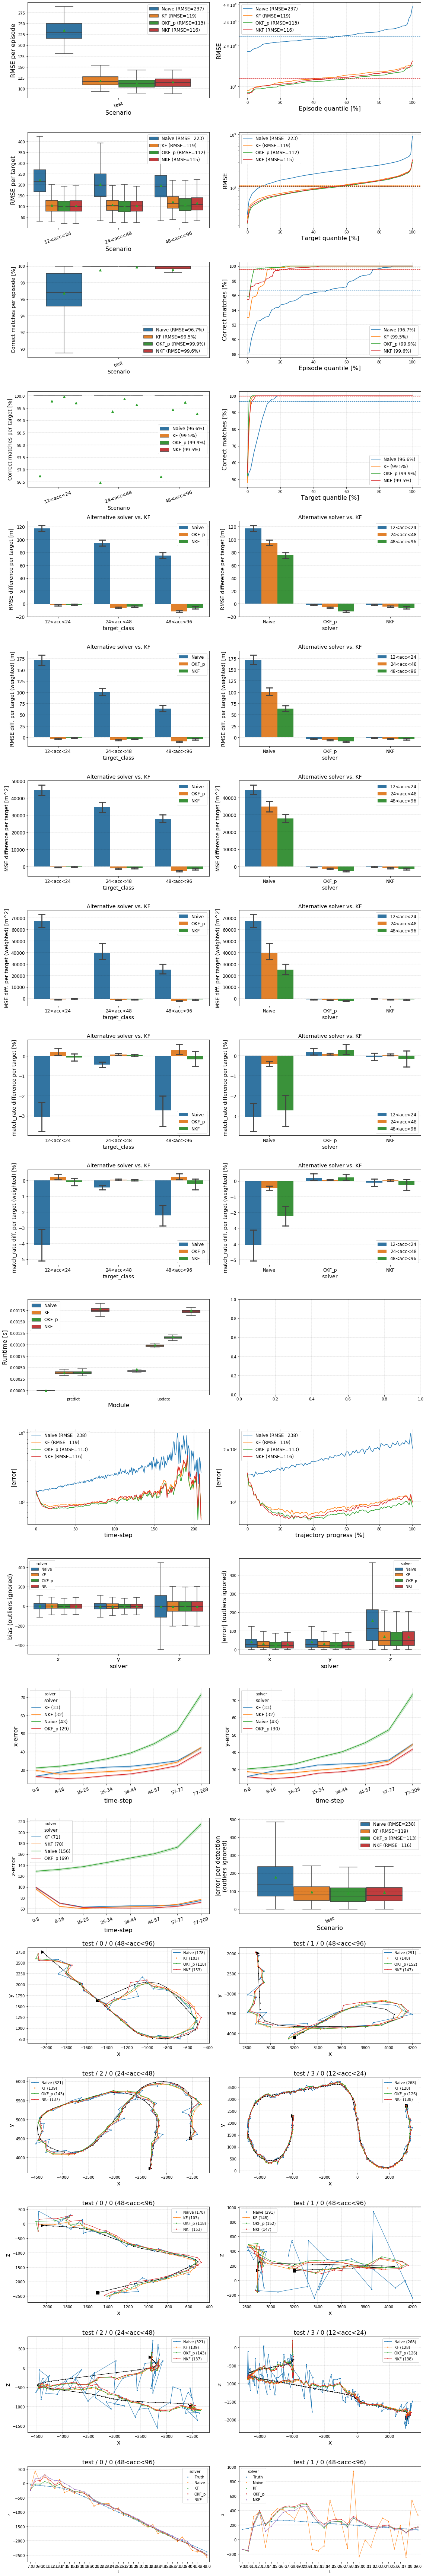

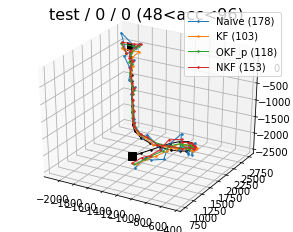

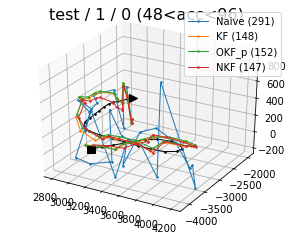

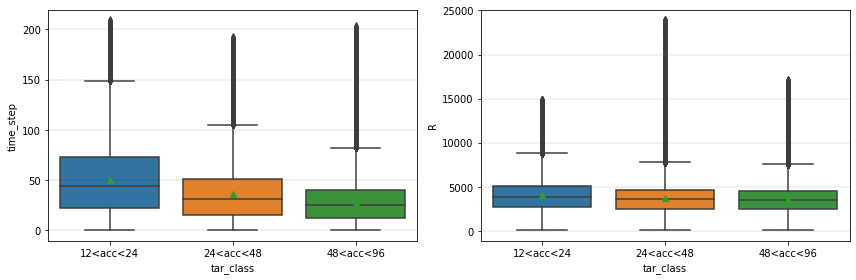

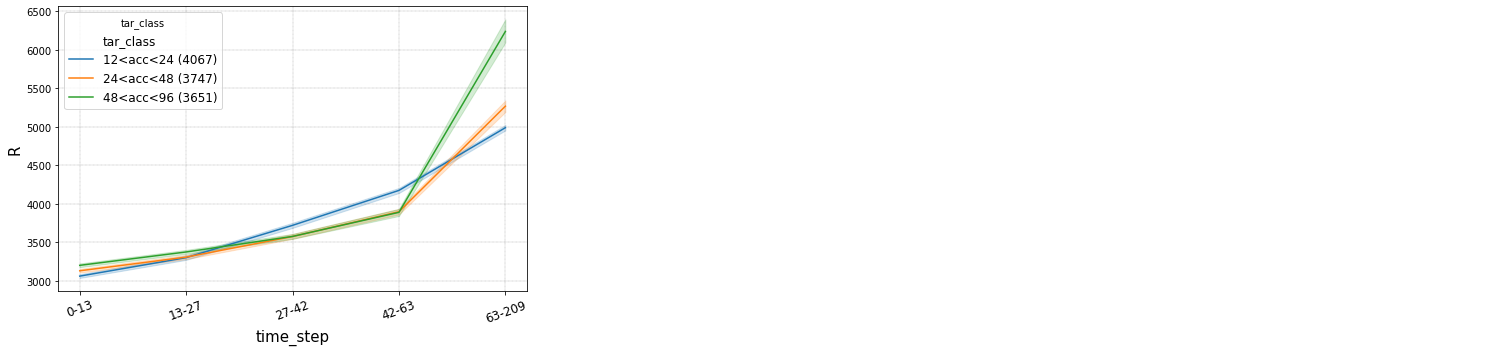

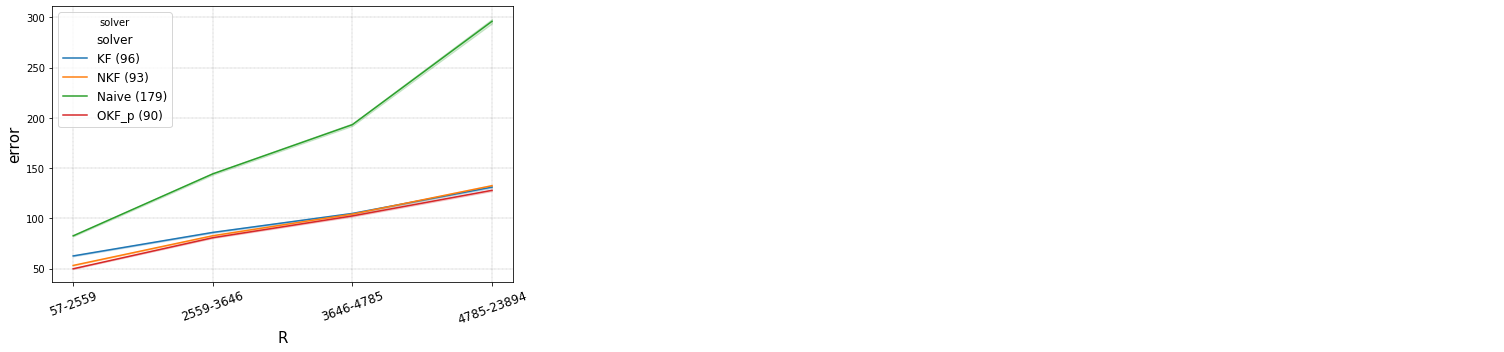

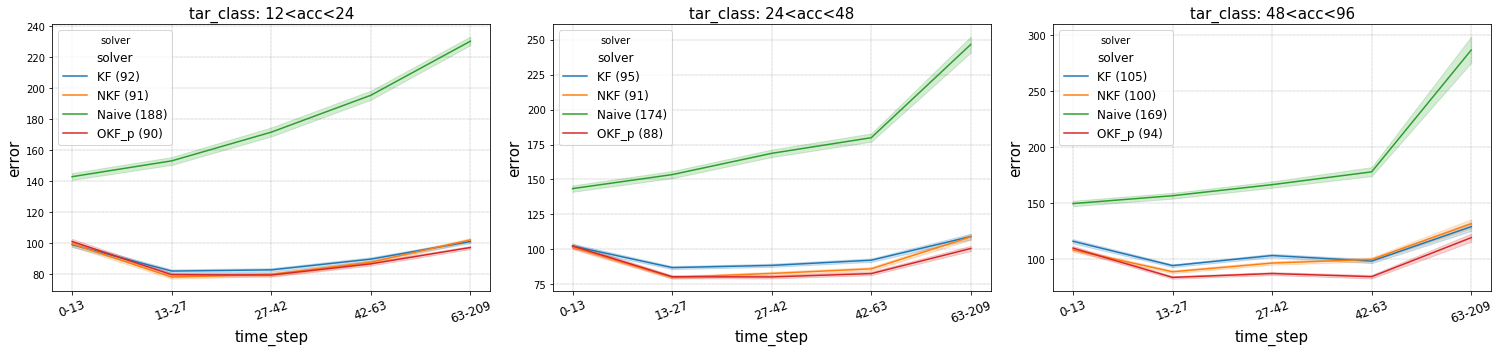

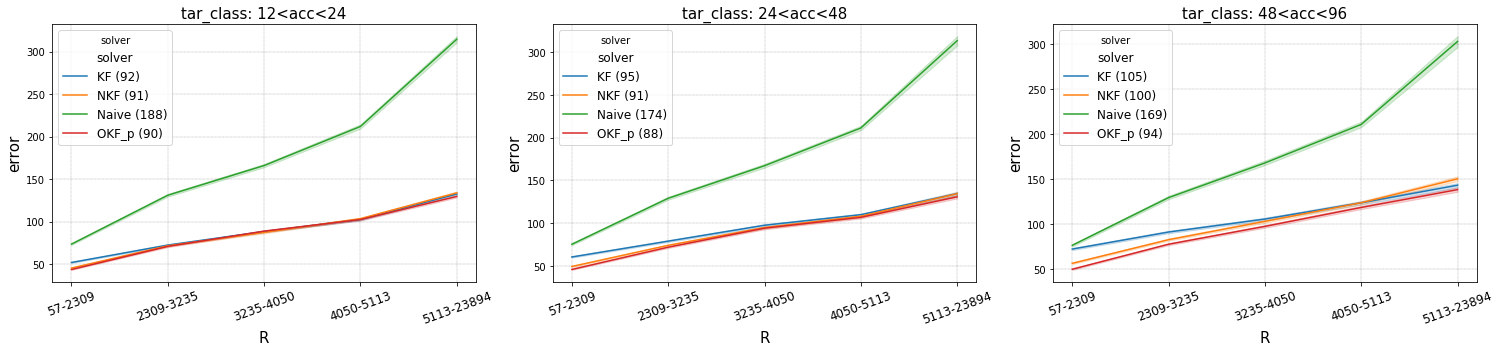

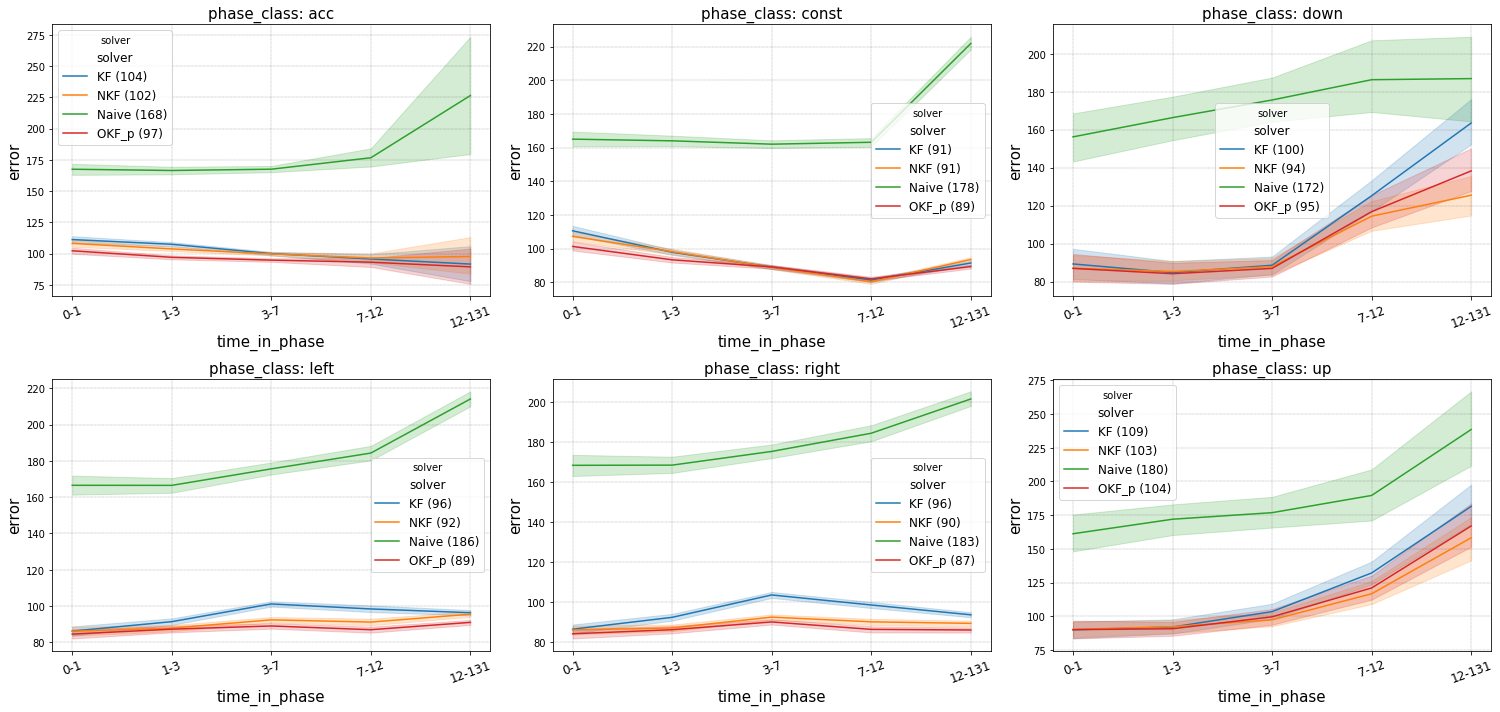

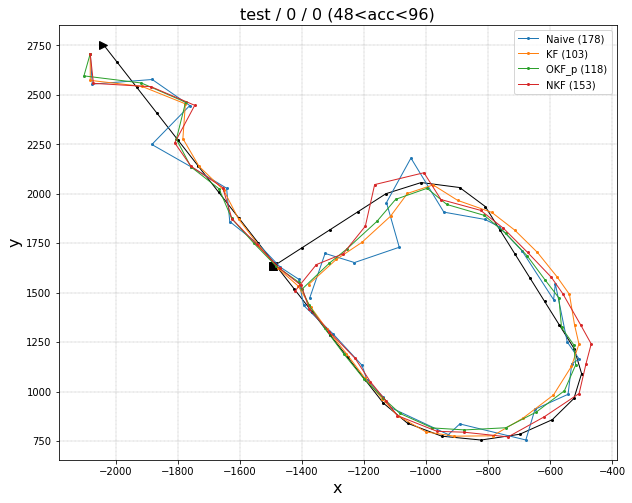

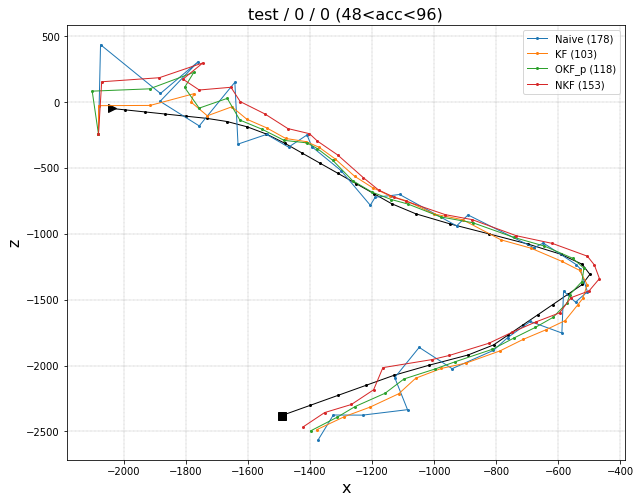

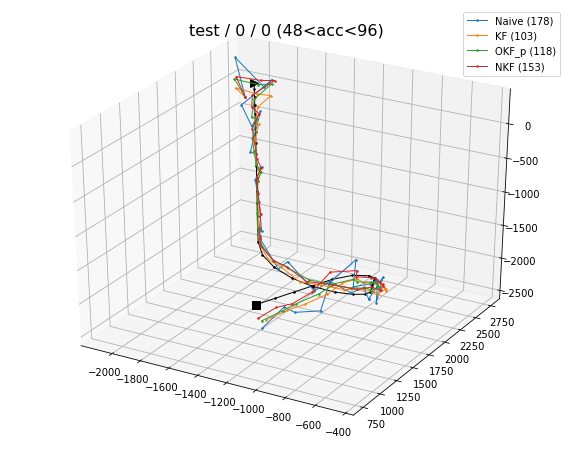

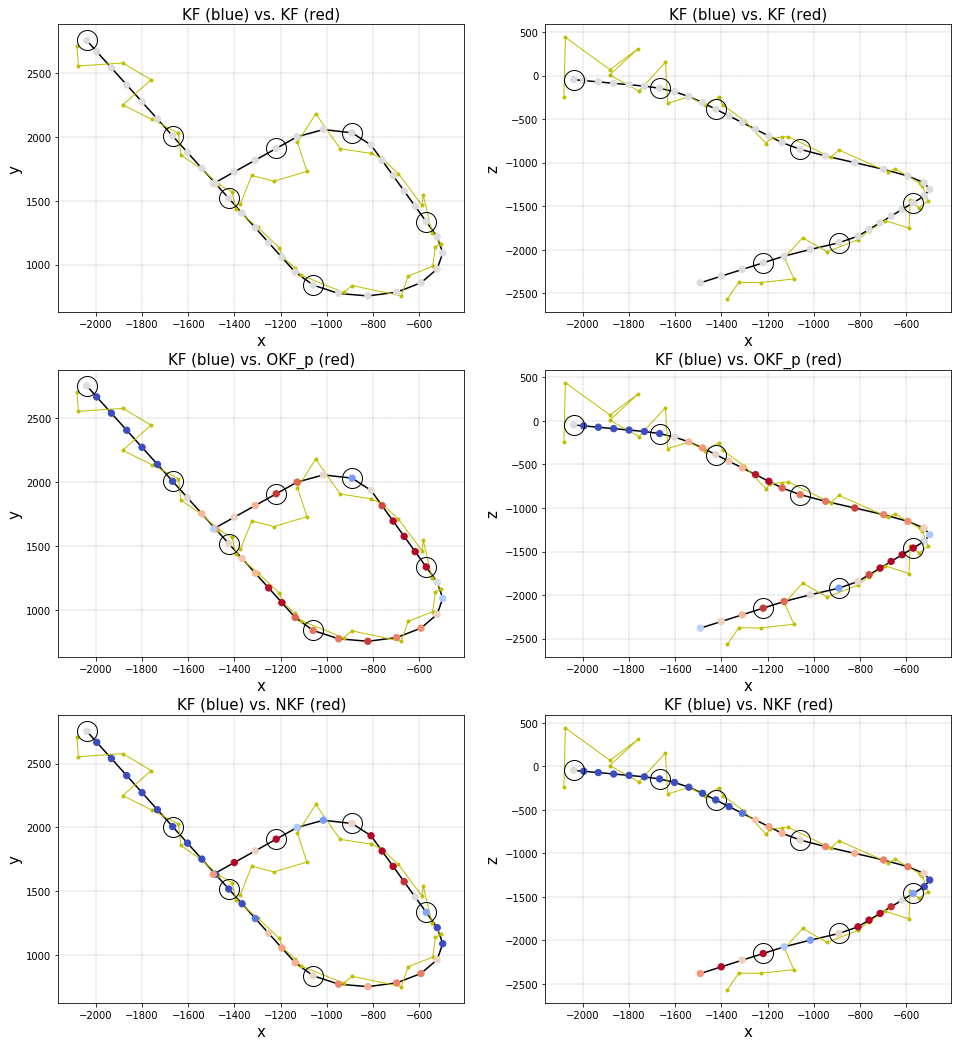

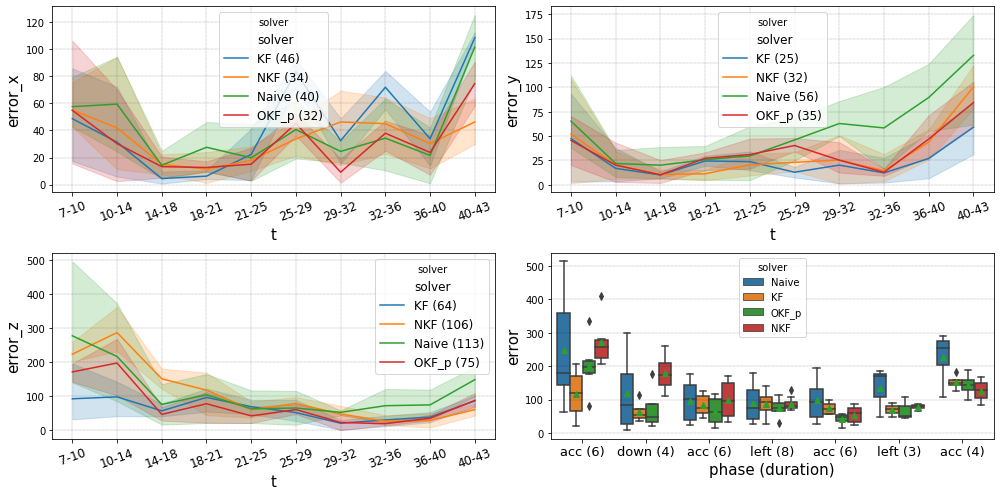

In [22]:
E.analyze_results(scenarios=['test'], ref_solver='KF', large=1); # group=1

**Errors correlation**: the correlations between the signed-errors of OKF_p & NKF (i.e. E.res.bias_x/y/z) are 83-4% for x,y dimensions and 93% for z.
When using the simple average of the two (which would be quite a computational overkill), the RMSE is only slightly reduced compared to OKF_p - by around 30% of the original difference between OKF_p & NKF.

   phase      mode  time        acc   direct      angle
0      0  straight    17   0.000000  forward   0.000000
1      1      turn     2  49.507299    right  95.351834
2      2  straight     4  84.644238  forward   0.000000
3      3      turn     4  56.900689    right  76.356460
4      4  straight     4  72.148707  forward   0.000000
5      5      turn     4  17.702421     down -26.210674
6      6  straight     4  94.957482  forward   0.000000


[<utils.Axes at 0x7fc11f4f2890>, <utils.Axes at 0x7fc11ef8b990>]

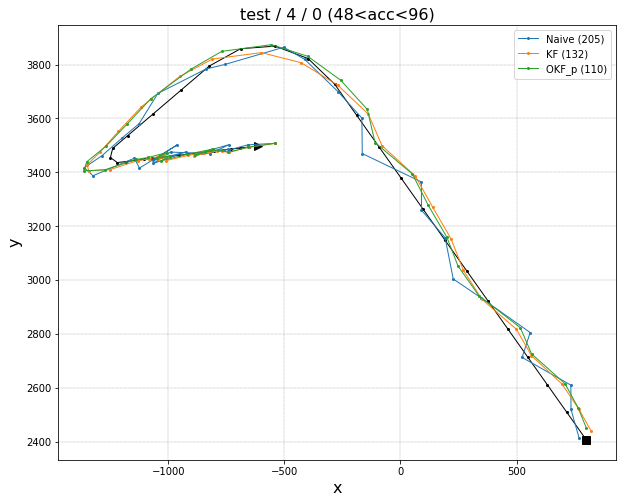

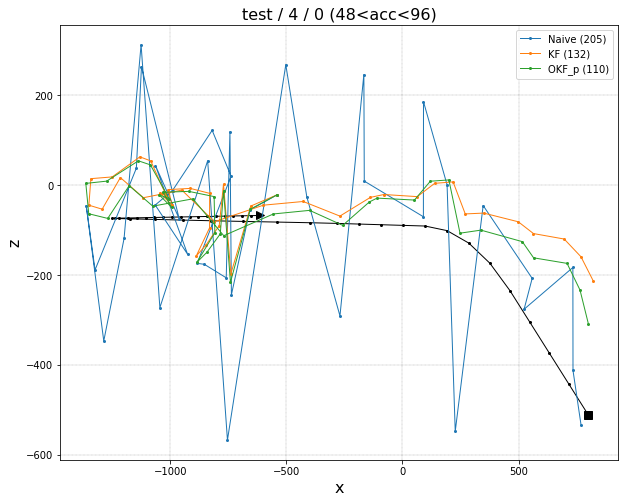

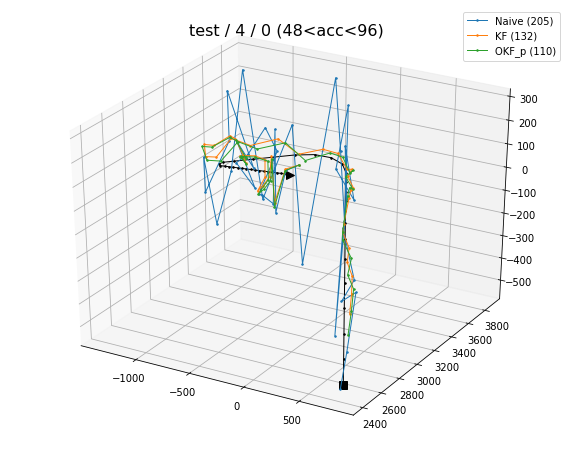

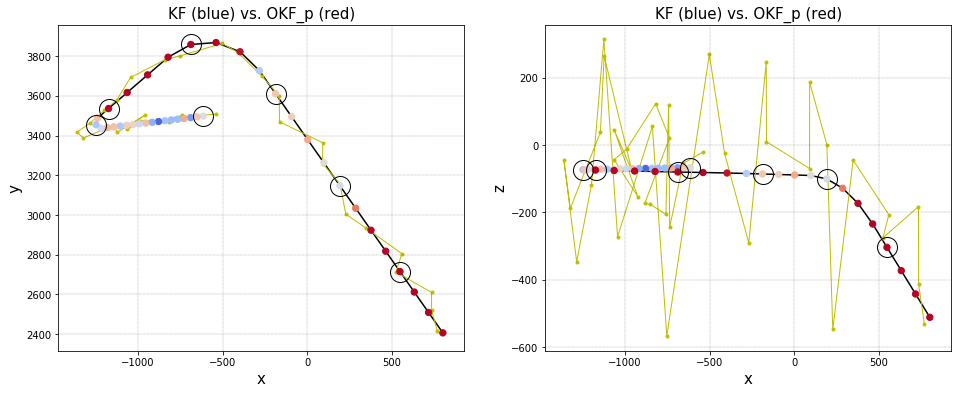

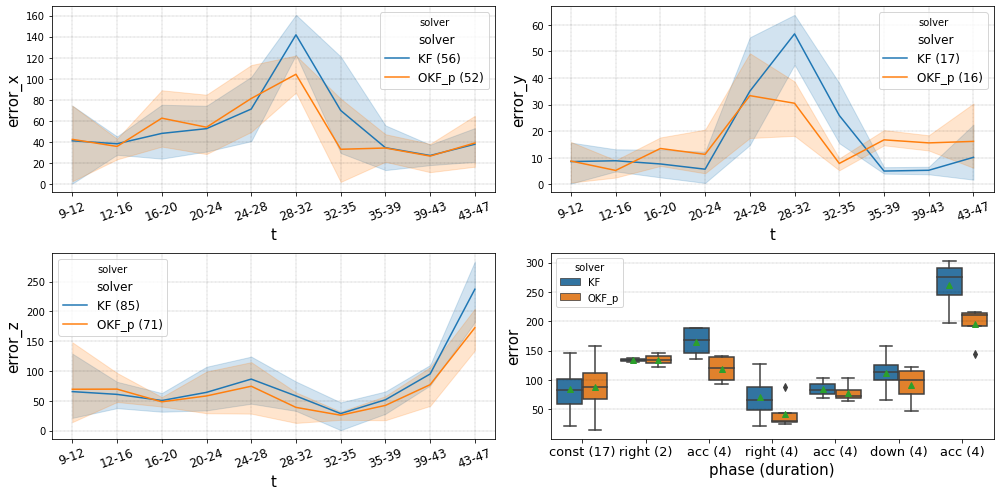

In [25]:
E.target_analysis('test',4,0, solvers=['KF','OKF_p'])

In [26]:
# ax = E.plot_trajectories_3d(['test'],[2],[3], solvers=['KF','OKF_p','NKF'], figsize=(12,12))[0]
# ax.view_init(30, 45)

# plt.figure()
# for col in ('Naive', 'KF','OKF_p','NKF'):
#     plt.plot(np.sqrt(E.targets['test'][2][3][f'SE_{col}']), label=col)
# plt.grid()
# plt.xlabel('time')
# plt.ylabel('square error')
# plt.legend();

In [27]:
# axs = E.plot_trajectories_3d(scenarios=('acc32',), episodes=[0], targets=[0], n_targets=1, figsize=(12,10), solvers=['Naive','KF','OKF_p','NKF'])
# axs[0].set_xlim((-500,0))
# axs[0].set_ylim((-50,900))
# axs[0].set_zlim((-100,0))
# axs[0].view_init(20, 90)